Deep Learning models are often considered as a black box and hard to interpret. Well, this statement is neither completely true nor it is completely false. It is a fact that debugging a deep learning model is way harder than other machine learning models but there are ways by which you can get insights about your model and to an extent, you can see what is happening.

REf[]:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
https://medium.com/intelligentmachines/implementation-of-class-activation-map-cam-with-pytorch-c32f7e414923
https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-class-activation-maps-fe94eda4cef1
https://arxiv.org/pdf/1512.04150.pdf
https://github.com/zhoubolei/CAM


In [ ]:
!unzip data.zip

In [36]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.autograd import Variable
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

plt.ion()   # interactive mode

In [41]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


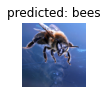

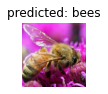

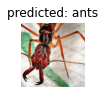

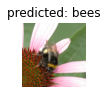

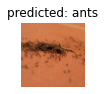

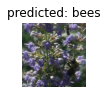

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [18]:
params = list(model_conv.parameters())
weight = np.squeeze(params[-1].data.numpy())

In [20]:
def return_CAM(feature_conv, weight, class_idx):
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [21]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

In [42]:
   
img_pil = Image.open("data/hymenoptera_data/val/ants/Hormiga.jpg")
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = model_conv(img_variable)

h_x = F.softmax(logit, dim=1).data.squeeze()
 
probs, idx = h_x.sort(0, True)
probs = probs.detach().numpy()
idx = idx.numpy()
    
#predicted_labels.append(idx[0])
#predicted =  train_loader.dataset.classes[idx[0]]
    
#print("Target: " + fname + " | Predicted: " +  predicted) 
 
features_blobs = mod(img_variable)
features_blobs1 = features_blobs.cpu().detach().numpy()
CAMs = return_CAM(features_blobs1, weight, [idx[0]])

readImg = "data/hymenoptera_data/val/ants/Hormiga.jpg"
img = cv2.imread(readImg)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.5 + img * 0.5
  
cv2.imwrite("image_1", result)

NameError: ignored